In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import math

# TEST ASSUMPTIONS
import statsmodels.stats.api as sms # homoskedasticity
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white # homoskedasticity
from scipy.stats import bartlett # homoskedasticity
from scipy.stats import normaltest # for normal distribution
from statsmodels.stats import diagnostic as diag # autocorellation (not so important)
import statsmodels.api as sm # autocorellation (not so important)

# LASSO model selection
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso

# CREATED FUNCTIONS
from ufc_func import *

# OUTLIERS
from scipy import stats

In [2]:
df = pd.read_csv("./ufc.csv")
df = pd.DataFrame(df)
df

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith
7413,"Denver, Colorado, USA",Frank Hamaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Morris
7414,"Denver, Colorado, USA",Johnny Rhodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7415,"Denver, Colorado, USA",Patrick Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our dataframe contains some null rows, so will need to remove it. Additionally column with "Time" doesn't useful for our aims in this represantation. We need to convert it to another units (to seconds).

In [3]:
df = df.dropna()
df_with_time = df.copy()

df_with_time["Seconds"] = df_with_time["Time"].apply(time_converter) + df_with_time["Round"].apply(round_converter)
df_with_time


,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0


Also some there are some "strange" fights: fighter 1 and fighter 2 both loss in fight.

In [4]:
df_with_time.tail(10)

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
7403,"Denver, Colorado, USA",Royce Gracie,Fred Ettish,1.0,0.0,13.0,4.0,0.0,0.0,1.0,0.0,Open Weight,SUB Bulldog Choke,1.0,3:07,UFC 2,11-Mar-94,Remco Pardoel,187.0
7404,"Denver, Colorado, USA",Patrick Smith,Scott Morris,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,Open Weight,KO/TKO Elbows,1.0,0:30,UFC 2,11-Mar-94,Johnny Rhodes,30.0
7405,"Denver, Colorado, USA",Royce Gracie,Minoki Ichihara,0.0,0.0,2.0,3.0,1.0,0.0,2.0,0.0,Open Weight,SUB Armbar,1.0,5:08,UFC 2,11-Mar-94,Patrick Smith,308.0
7406,"Denver, Colorado, USA",Remco Pardoel,Scott Baker,0.0,0.0,3.0,0.0,0.0,1.0,5.0,0.0,Open Weight,SUB Triangle Choke,1.0,6:41,UFC 2,11-Mar-94,Royce Gracie,401.0
7407,"Denver, Colorado, USA",Johnny Rhodes,Alberta Cerra Leon,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,Open Weight,SUB Ezekiel Choke,1.0,9:51,UFC 2,11-Mar-94,Jason DeLucia,591.0
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith,20.0


We need to remove it

In [5]:
df_with_time = df_with_time.loc[
    (df_with_time["Fighter 1"] == df_with_time["Winner"]) | 
    (df_with_time["Fighter 1"] == df_with_time["Winner"])].reset_index(drop=True)

Next, let us show average statistic per fight (including first and second fighter)

In [6]:
total_kd = (df["Fighter_1_KD"] + df["Fighter_2_KD"]).mean()
total_str= (df["Fighter_1_STR"] + df["Fighter_2_STR"]).mean()
total_td= (df["Fighter_1_TD"] + df["Fighter_2_TD"]).mean()
total_sub= (df["Fighter_1_SUB"] + df["Fighter_1_SUB"]).mean()

print("Average knockdowns per fight: ", total_kd)
print("Average significant strikes per fight: ", total_str)
print("Average takedown attemps per fight: ", total_td)
print("Average submissions attemps per fight: ", total_sub)

Average knockdowns per fight:  0.4305180787911495
Average significant strikes per fight:  71.68497031840259
Average takedown attemps per fight:  2.1184565569347007
Average submissions attemps per fight:  1.0642201834862386


As we can see knockdowns is the rarest fight moment. Now let us look what type of finishes UFC fight can have:

In [7]:
methods = df_with_time["Method"].unique()

methods

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'Overturned', 'KO/TKO Elbows',
       'KO/TKO Kick', 'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC',
       'SUB Arm Triangle', 'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'DQ',
       'SUB Anaconda Choke', 'SUB Ezekiel Choke', 'SUB Triangle Choke',
       'SUB Twister', 'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'Overturned Guillotine Choke',
       'KO/TKO Elbow', 'SUB Other - Lock', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'Overturned Punches',
       'SUB Ankle Lock', 'SUB Forearm Choke', 'SUB Injury',
       'Overturned Punch', 'Overturned Rear Naked Choke',
       'Overturned Knee', 'O

There are lots of different type of finishes, but all them come down to KO/TKO, SUB, DEC, CNC. Overturned, Other and DQ are useless characteristic for our research.

In [8]:
df_fil = methods_destroyer(df_with_time)

df_fil["Method"].unique()

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'KO/TKO Elbows', 'KO/TKO Kick',
       'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC', 'SUB Arm Triangle',
       'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'SUB Anaconda Choke',
       'SUB Ezekiel Choke', 'SUB Triangle Choke', 'SUB Twister',
       'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'KO/TKO Elbow', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'SUB Ankle Lock',
       'SUB Forearm Choke', 'SUB Injury', 'SUB Peruvian Necktie',
       'SUB Schultz Front Headlock', 'SUB Bulldog Choke',
       'SUB Suloev Stretch', 'SUB Omoplata', 'SUB Calf Slicer',
       'SUB North-South Choke', 'SUB Pac

Now this data can be useful, we can plot distribution of methods if we remove additional information, like "Armbar", "Punch" and so on.

In [9]:
df_methods = df_fil.copy()
df_methods["Method"] = df_fil["Method"].apply(replace_method)
df_methods["Method"].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

Now we can plot histogram of distribtuion

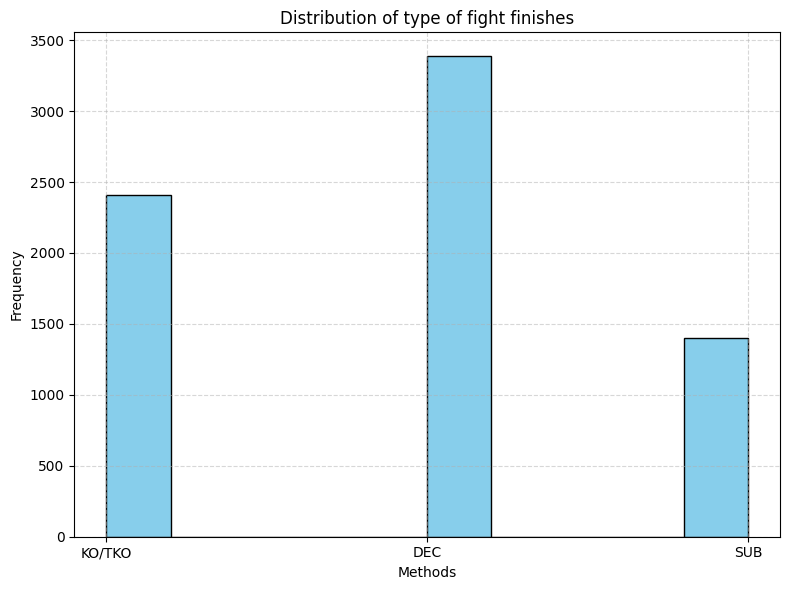

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(df_methods["Method"], color='skyblue', edgecolor='black')
plt.title('Distribution of type of fight finishes')
plt.xlabel('Methods')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now let us take a look at "Weight_Class".

In [11]:
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       'Catch Weight', "Women's Featherweight", 'Super Heavyweight',
       'Open Weight'], dtype=object)

Some of these categories are not used in UFC, so we will drop them 

In [12]:
df_fil = weight_destroyer(df_fil)
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       "Women's Featherweight"], dtype=object)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

In [13]:
three, five = df_breaker_by_rounds(df_fil)

df_fil = three.copy()

df_fil

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,"Mobile, Alabama, USA",Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,Middleweight,S-DEC,2.0,3:00,UFC 17,15-May-98,Dan Henderson,480.0
7263,"Mobile, Alabama, USA",David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,Heavyweight,KO/TKO Punches,1.0,0:43,UFC 17,15-May-98,David Abbott,43.0
7264,"Mobile, Alabama, USA",Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,Heavyweight,SUB Keylock,1.0,11:01,UFC 17,15-May-98,Mike van Arsdale,661.0
7265,"Mobile, Alabama, USA",Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,Middleweight,SUB Triangle Choke,1.0,0:52,UFC 17,15-May-98,Carlos Newton,52.0


Now, we are going to remove all unneccassary columns: Date (data doesn't depend on date), Event Name, Round, Time, Location.

In [14]:
df_fil = de_remover(df_fil)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

Finally, our dataframe is ready to be used in project. But before, we will run logit and OLS models, let us create dataframe with fighters statistic.

In [15]:
fighters = list(set(df_fil["Fighter 1"].unique()).union(set(df_fil["Fighter 2"].unique())))
fighters_df = pd.DataFrame({"Fighter_name": [],
                            "Average_significant_strikes": [],
                            "Average_takedowns": [],
                            "Average_submission_attempts": [],
                            "Average_knockdowns": [],
                            "Average_activity": [],
                            "Wins": [],
                            "Loss": [],
                            "Winrate": []})


for ele in fighters:
    win_df = df_fil.loc[df_fil["Fighter 1"] == ele]
    lose_df = df_fil.loc[df_fil["Fighter 2"] == ele]

    wins, losses = int(len(win_df.index)), int(len(lose_df.index))

    amount_of_mentions = wins + losses

    avg_strk = round((win_df["Fighter_1_STR"].sum() + lose_df["Fighter_2_STR"].sum())/amount_of_mentions, 2)
    avg_tkd = round((win_df["Fighter_1_TD"].sum() + lose_df["Fighter_2_TD"].sum())/amount_of_mentions, 2)
    avg_subs = round((win_df["Fighter_1_SUB"].sum() + lose_df["Fighter_2_SUB"].sum())/amount_of_mentions, 2)
    avg_kd = round((win_df["Fighter_1_KD"].sum() + lose_df["Fighter_2_KD"].sum())/amount_of_mentions, 2)
    # weight_class = pd.concat([lose_df["Weight_Class"], win_df["Weight_Class"]])

    avg_act = avg_strk + avg_tkd + avg_subs + avg_kd

    data = {
        "Fighter_name": [ele],
        "Average_significant_strikes": [avg_strk],
        "Average_takedowns": [avg_tkd],
        "Average_submission_attempts": [avg_subs],
        "Average_knockdowns": [avg_kd],
        "Average_activity": [avg_act],
        "Wins": [wins],
        "Loss": [losses],
        "Winrate": [round(wins/(wins+losses), 2)],
        # "Weight_class": [weight_class.unique()]
    }

    fighters_df = pd.concat([fighters_df, pd.DataFrame(data)], ignore_index = True)

fighters_df

,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate
0,Brady Hiestand,43.33,4.00,0.33,0.0,47.66,2.0,1.0,0.67
1,Wu Yanan,51.50,0.50,0.17,0.0,52.17,1.0,5.0,0.17
2,Modestas Bukauskas,30.71,0.00,0.00,0.0,30.71,3.0,4.0,0.43
3,Ian Freeman,16.50,0.50,0.33,0.0,17.33,3.0,3.0,0.50
4,Khabib Nurmagomedov,42.60,5.00,0.70,0.2,48.50,10.0,0.0,1.00
...,...,...,...,...,...,...,...,...,...
2308,Myktybek Orolbai,8.00,7.00,1.00,0.0,16.00,1.0,0.0,1.00
2309,Elizabeth Phillips,39.00,0.75,0.25,0.0,40.00,1.0,3.0,0.25
2310,Parker Porter,46.12,0.62,0.12,0.0,46.86,4.0,4.0,0.50
2311,Milton Vieira,23.50,3.00,0.00,0.0,26.50,0.0,2.0,0.00


In [16]:
fighters_df = pd.read_csv("./app/data/fighter.csv")

fighters_df = pd.DataFrame(fighters_df)

fighter_weight = fighters_df[fighters_df["Weight_class"].apply(lambda x: "Welterweight" in x)].reset_index(drop=True)

fighter_weight['Fighter_name'].to_list()

['Alexander Yakovlev',
 'Rodrigo de Lima',
 'Sean Spencer',
 'Nathan Coy',
 'Ryan McGillivray',
 'Yancy Medeiros',
 'Mike Rhodes',
 'Shavkat Rakhmonov',
 'Darrius Flowers',
 'Josh Neer',
 'John Howard',
 'Dan Stittgen',
 'Che Mills',
 'Hernani Perpetuo',
 'Sean Brady',
 'Adrian Serrano',
 'John Alessio',
 'Francisco Trinaldo',
 'James Head',
 'Chris Wilson',
 'Tom Breese',
 'Marcio Alexandre Junior',
 'Wendell Oliveira Marques',
 'Jon Manley',
 'Chris Brennan',
 'Stephen Thompson',
 'Bojan Velickovic',
 'Ben Alloway',
 'Matthew Riddle',
 'Ramsey Nijem',
 'Rostem Akman',
 'Rafael Dos Anjos',
 'Zak Ottow',
 'Brandon Thatch',
 'Clay Harvison',
 'Ricardo Almeida',
 'Rich Attonito',
 'Kyle Noke',
 'Lyman Good',
 'Matt Brown',
 'Amir Sadollah',
 'Alex Morono',
 'Joe Stevenson',
 'Khamzat Chimaev',
 'Jonathan Meunier',
 'Kyle Bradley',
 'Paul Bradley',
 'Jake Hecht',
 'Jason Gilliam',
 'Nate Marquardt',
 'Justin Edwards',
 'Kyle Prepolec',
 'Micheal Gillmore',
 'Kamaru Usman',
 'Gil Castillo'

In [17]:
fighters_df

,Unnamed: 0,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate,Weight_class
0,0,Irwin Rivera,50.33,1.00,0.00,0.00,51.33,1.0,2.0,0.33,['Bantamweight' 'Featherweight']
1,1,Nathaniel Wood,69.89,1.67,0.44,0.22,72.22,7.0,2.0,0.78,['Featherweight' 'Bantamweight']
2,2,Ricardo Ramos,29.82,1.73,0.45,0.27,32.27,7.0,4.0,0.64,['Featherweight' 'Bantamweight']
3,3,Mara Romero Borella,23.86,1.14,0.14,0.00,25.14,2.0,5.0,0.29,"[""Women's Flyweight""]"
4,4,Edmen Shahbazyan,27.00,1.22,0.33,0.33,28.88,5.0,4.0,0.56,['Middleweight']
...,...,...,...,...,...,...,...,...,...,...,...
2308,2308,Dan Ige,44.00,0.85,0.08,0.38,45.31,9.0,4.0,0.69,['Featherweight']
2309,2309,Melissa Gatto,50.50,1.00,0.25,0.25,52.00,2.0,2.0,0.50,"[""Women's Flyweight""]"
2310,2310,Kamuela Kirk,35.33,1.00,1.33,0.00,37.66,1.0,2.0,0.33,['Lightweight' 'Featherweight']
2311,2311,Caio Magalhaes,18.43,0.57,0.86,0.29,20.15,4.0,3.0,0.57,['Middleweight']


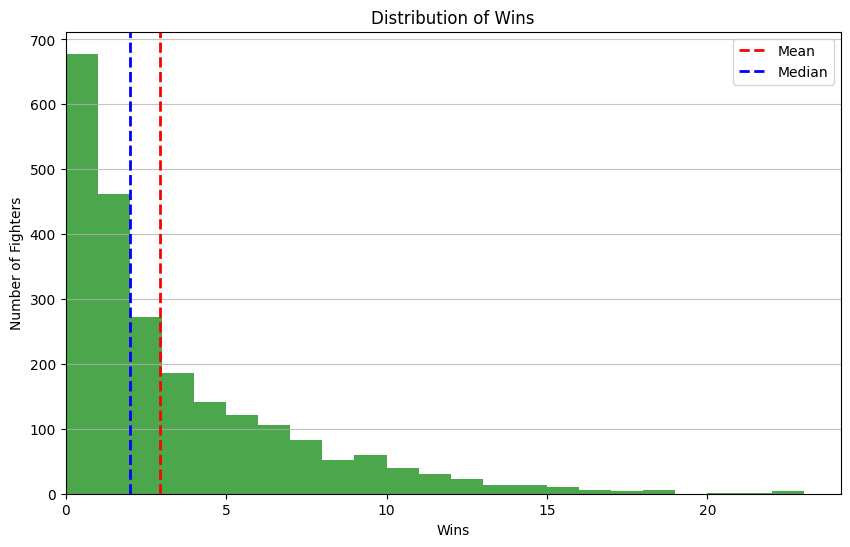

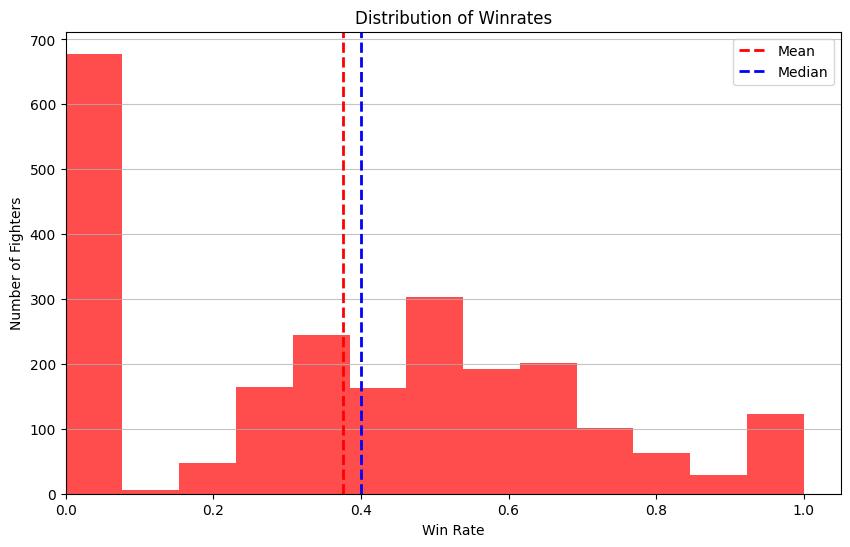

In [18]:
mean_wins = fighters_df["Wins"].mean()
median_wins = fighters_df["Wins"].median()

plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Wins"], bins=int(fighters_df["Wins"].max()), color='green', alpha=0.7)
plt.title('Distribution of Wins')
plt.xlabel('Wins')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wins, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wins, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()

plt.show()

mean_wr = fighters_df["Winrate"].mean()
median_wr = fighters_df["Winrate"].median()
plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Winrate"], bins='auto', color='red', alpha=0.7)
plt.title('Distribution of Winrates')
plt.xlabel('Win Rate')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wr, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wr, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()
plt.show()

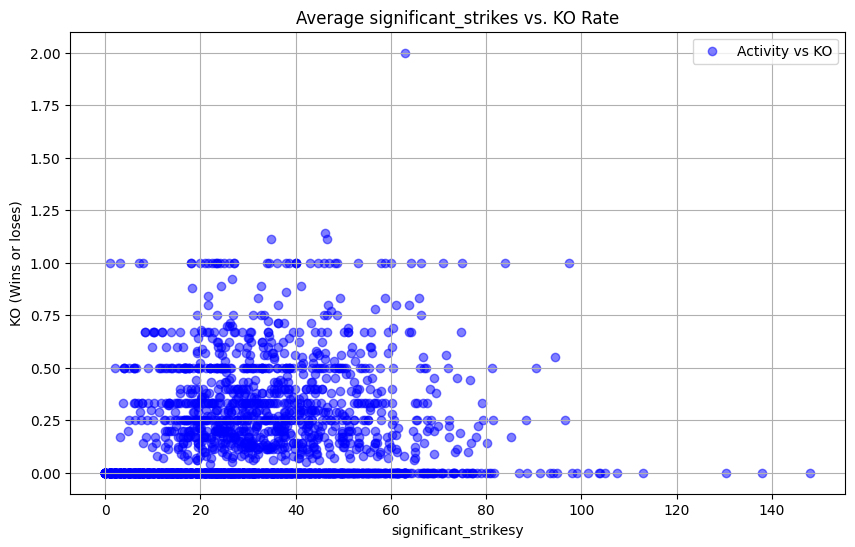

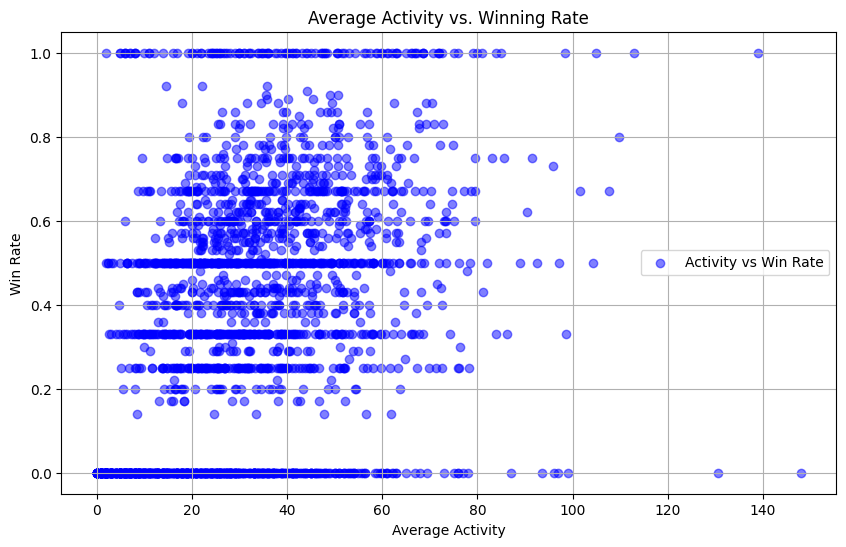

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_significant_strikes"], fighters_df["Average_knockdowns"], color='blue', alpha=0.5, label='Activity vs KO')
plt.title('Average significant_strikes vs. KO Rate')
plt.xlabel('significant_strikesy')
plt.ylabel('KO (Wins or loses)')
plt.legend()
plt.grid(True)
plt.show()

# Improved Scatter plot for Average Activity vs. Win Rate
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_activity"], fighters_df["Winrate"], color='blue', alpha=0.5, label='Activity vs Win Rate')
plt.title('Average Activity vs. Winning Rate')
plt.xlabel('Average Activity')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# cor_df = fighters_df.drop(["Fighter_name"], axis=1)
# correlation_matrix = cor_df.corr()


# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
# plt.title('Correlation Matrix of Fighter Statistics')
# plt.show()

# OLS

Now, we are going to construct OLS method for predicting the duration of fight in seconds. However, our dataframe contains male and female fighters and it is not relevant to predict duration fight in combined dataframe, because man and woman can not have much up in UFC, so we are going to divide dataframe in two: for males and for females

In [21]:
df_fil["Gender"] = np.where(df_fil["Weight_Class"].str.contains("Women"), 1, 0)
df_man = df_fil.loc[df_fil["Gender"] == 0].drop(["Gender"], axis=1).reset_index(drop=True)
df_woman = df_fil.loc[df_fil["Gender"] != 0].drop(["Gender"], axis=1).reset_index(drop=True)

Variables in "Weight_Class" is ordinal, so to make our future OLS more relevent, we need to divide this column to many distinct columns. Each this column will represent the distinct weight category, so if fighters belong to this category we will put 1, if not 0 (It is clear that fighters in one fight can only belongs to one category).

In [22]:
df_man_clear = weight_breaker(df_man)
df_woman_clear = weight_breaker(df_woman)

df_man_clear

,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Winner,Seconds,Lightweight,Bantamweight,Welterweight,Middleweight,Light Heavyweight,Featherweight,Heavyweight,Flyweight
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,Arman Tsarukyan,64.0,1,0,0,0,0,0,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,Jalin Turner,169.0,1,0,0,0,0,0,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,Deiveson Figueiredo,900.0,0,1,0,0,0,0,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,Sean Brady,703.0,0,0,1,0,0,0,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,Joaquim Silva,900.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,Dan Henderson,480.0,0,0,0,1,0,0,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,David Abbott,43.0,0,0,0,0,0,0,1,0
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,Mike van Arsdale,661.0,0,0,0,0,0,0,1,0
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,Carlos Newton,52.0,0,0,0,1,0,0,0,0


In [23]:
winrates_df = history_winrate(df_man_clear)

In [24]:


names = [ele.replace(" ", "_") for ele in winrates_df.columns.to_list()]
winrates_df.columns = names

winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Lightweight,Bantamweight,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.88,0.77
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.59
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0.75,0.75
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0.83,0.75
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1.00,1.00
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0.00,0.00


In [25]:
categories_all = [ele for ele in winrates_df.columns if "Fighter" in ele or "winrate" in ele]
categories = [(categories_all[i], categories_all[i+1]) for i in range(0, len(categories_all), 2)]

swapper(winrates_df, categories)



We have lots of zeroes in this dataframe so let us try to remove them or make more meaningful

In [26]:
winrates_df['Winrate_1_is_0'] = np.where(winrates_df["Current_winrate_F1"] == 0, 1, 0)
winrates_df['Winrate_2_is_0'] = np.where(winrates_df["Current_winrate_F2"] == 0, 1, 0)

In [27]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.77,0.88,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,1,0,0,0,0,0,0.83,0.75,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Bob Gilstrap,Carlos Newton,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# OLS

In [28]:
winrates_df["Seconds"].value_counts()

Seconds
900.0    2686
600.0      39
300.0      20
299.0      20
255.0      15
         ... 
319.0       1
390.0       1
701.0       1
670.0       1
601.0       1
Name: count, Length: 820, dtype: int64

In [29]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_Time=smf.ols(f"Seconds ~ {' + '.join(winrates_df_model)}", data=winrates_df)
print(model_Time.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     582.0
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:28:45   Log-Likelihood:                -41055.
No. Observations:                6136   AIC:                         8.215e+04
Df Residuals:                    6116   BIC:                         8.229e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.0634     15

Now It is seem that weight class in unsignificant variable, so let test their joint significance

In [30]:
weights = winrates_df[['Bantamweight', 'Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight']]

test_model = smf.ols(formula=f"Seconds ~ {' + '.join(weights.columns)}", data=winrates_df).fit()

f_statistic = test_model.fvalue
p_value = test_model.f_pvalue


if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


It seems their are significant. Now let perform model selection with AIC to create the best model

In [31]:
# LASSO SELECTION IS DONE
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(winrates_df_model, winrates_df["Seconds"])
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


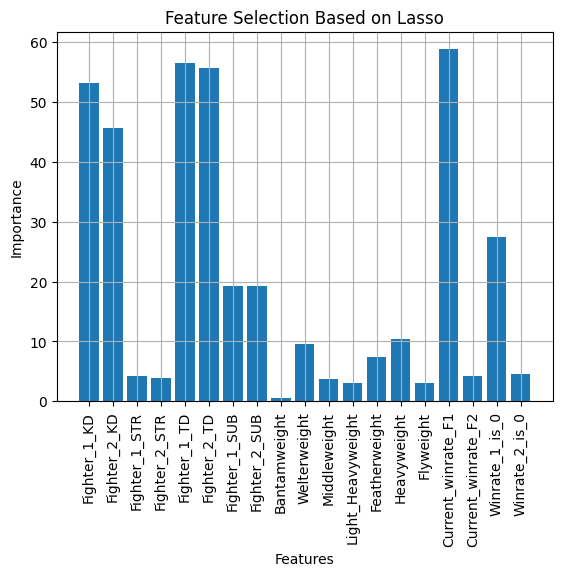

In [32]:

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(winrates_df_model, winrates_df["Seconds"])

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

names = winrates_df_model.columns
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [33]:

selected_model = winrates_df_model[np.array(names)[lasso1_coef>3]]

selected_model

,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Welterweight,Middleweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.77,0.88,0,0
1,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.59,0.56,0,0
2,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,0,0,0,0,0,0.75,0.75,0,0
3,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,1,0,0,0,0,0.83,0.75,0,0
4,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,0,1,0,0,0,1.00,1.00,0,0
6132,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0,0,0,1,0,0.00,0.00,1,1
6133,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,0,0,0,1,0,0.00,0.00,1,1
6134,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0,1,0,0,0,0.00,0.00,1,1


In [34]:
model_Time_selected=smf.ols(f"Seconds ~ {' + '.join(selected_model)}", data=winrates_df).fit().summary()

model_Time_selected

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     650.6
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:28:47   Log-Likelihood:                -41055.
No. Observations:                6136   AIC:                         8.215e+04
Df Residuals:                    6118   BIC:                         8.227e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.1937     14.788     11.847      0.000     146.205     204.183
Fighter_1_KD         -53.1982      5.220    -10.191      0.000     -63.431     -42.965
Fighter_2_KD         -45.7605      5.169     -8.853      0.000     -55.894     -35.627
Fighter_1_STR          4.2152      0.120     35.061      0.000       3.980       4.451
Fighter_2_STR          3.9498      0.120     33.002      0.000       3.715       4.184
Fighter_1_TD          56.5347      1.581     35.750      0.000      53.435      59.635
Fighter_2_TD          55.6163      1.620     34.335      0.000      52.441      58.792
Fighter_1_SUB         19.2927      3.059      6.308      0.000      13.297      25.289
Fighter_2_SUB         19.2159      3.040      6.321      0.000      13.256      25.175
Welterweight           9.3567      7.311      1.280      0.201      -4.976      23.689
Middleweight           3.4577      7.875      0.439      0.661     -11.981      18.896
Featherweight         -7.5414      8.813     -0.856      0.392     -24.818       9.735
Heavyweight          -12.1342      7.297     -1.663      0.096     -26.439       2.171
Flyweight              2.8808     12.243      0.235      0.814     -21.120      26.881
Current_winrate_F1    58.8993     14.231      4.139      0.000      31.001      86.798
Current_winrate_F2     4.1962     14.382      0.292      0.770     -23.998      32.390
Winrate_1_is_0        27.6008     11.270      2.449      0.014       5.508      49.694
Winrate_2_is_0        -4.4431     11.335     -0.392      0.695     -26.664      17.778
==============================================================================
Omnibus:                       42.980   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.069
Skew:                           0.194   Prob(JB):                     4.44e-10
Kurtosis:                       2.865   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us calculate accuracy score for OLS model. To do it, we will need to convert preditions of variable "Second" into ordinal variable "Round" (the same we will need to perform with true values, because column "Round" was dropped at the beginning of research), however accuracy score is bad in distinguish between different classes so we will use f1 score for this purposes

In [35]:
predictor_data = winrates_df_model

predictions = model_Time.fit().predict(predictor_data)

print(predictions)

0       218.306535
1       359.928628
2       817.034105
3       707.271692
4       834.346064
           ...    
6131    647.371580
6132    287.611391
6133    412.291665
6134    318.980054
6135    451.819660
Length: 6136, dtype: float64


In [83]:
accuracy_win = winrates_df.copy()

accuracy_win["Second_Pred"] = predictions
accuracy_win["Round_Pred"] = accuracy_win["Second_Pred"].apply(second_to_round)
accuracy_win["Round"] = accuracy_win["Seconds"].apply(second_to_round)

conf_mat = metrics.confusion_matrix(accuracy_win["Round"], accuracy_win["Round_Pred"])
f_1_score = metrics.f1_score(accuracy_win["Round"], accuracy_win["Round_Pred"], average="macro")

pred_accuracy = (accuracy_win["Round_Pred"] == accuracy_win["Round"]).value_counts()

print(f"Accuracy: {round(pred_accuracy[0]/(pred_accuracy[0]+pred_accuracy[1]),2)}")
print(f_1_score)

Accuracy: 0.58
0.3018403533290372


In [37]:
winrates_df["Winner"] = pd.to_numeric(winrates_df["Winner"])

In [38]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.77,0.88,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,1,0,0,0,0,0,0.83,0.75,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Bob Gilstrap,Carlos Newton,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# Logit

In [39]:
winrates_df_model_logit = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=winrates_df)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.333961
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Thu, 25 Apr 2024   Pseudo R-squ.:                  0.5182
Time:                        20:28:47   Log-Likelihood:                -2049.2
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1138      0.236      0.481      0.630      -0.350       0.577
Fight

Let's calculate the accuracy score for logit model

In [40]:
predictor_data_logit = winrates_df_model_logit

predictions_logit = model_logit.fit().predict(predictor_data_logit)

Optimization terminated successfully.
         Current function value: 0.333961
         Iterations 7


Calculate the accuracy score for logit model

In [41]:
predictions_logit = np.where(predictions_logit > 0.5, 1, 0)

tp_and_fp = (winrates_df["Winner"] == predictions_logit).value_counts()

print(f"The accuracy score fot logit model: {(tp_and_fp[0]/(tp_and_fp[0]+tp_and_fp[1]))}")

The accuracy score fot logit model: 0.8714146023468058


In [42]:
metrics.f1_score(winrates_df['Winner'], predictions_logit)

0.869995056846268

In [43]:
history_avg = winrates_df.copy()

replace_stats_with_avg(history_avg)

history_avg

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.32,0.12,35.09,46.62,1.18,3.38,0.55,0.00,...,0,0,0,0,0,0,0.77,0.88,0,0
1,Bobby Green,Jalin Turner,0.18,0.33,74.73,38.89,0.91,0.33,0.23,0.67,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Rob Font,Deiveson Figueiredo,0.58,0.67,46.25,24.42,0.67,1.00,0.42,1.67,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Sean Brady,Kelvin Gastelum,0.17,0.31,52.17,44.88,2.33,0.94,0.67,0.12,...,1,0,0,0,0,0,0.83,0.75,0,0
4,Clay Guida,Joaquim Silva,0.18,0.22,31.26,35.44,2.24,0.11,0.47,0.33,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,1.00,0.00,31.00,1.00,1.00,1.00,1.00,3.00,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Bob Gilstrap,Carlos Newton,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0.00,0.00,1,1


Run new logit model for history_avg dataframe

In [44]:
model_logit2=smf.logit(f"Winner ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_logit2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.674334
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Thu, 25 Apr 2024   Pseudo R-squ.:                 0.02710
Time:                        20:28:59   Log-Likelihood:                -4137.7
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                 2.637e-38
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1545      0.163      0.948      0.343      -0.165       0.474
Fight

In [45]:
model_Time2=smf.ols(f"Seconds ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_Time2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     14.14
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           6.39e-45
Time:                        20:28:59   Log-Likelihood:                -44091.
No. Observations:                6136   AIC:                         8.822e+04
Df Residuals:                    6116   BIC:                         8.836e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            575.9599     25

# Some additional functions to work with dataframe

In [46]:
get_stats_of_fighter(fighters_df, "Arman Tsarukyan")
get_fights_of_fighter(winrates_df, "Arman Tsarukyan")

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.77,0.88,0,0
193,Arman Tsarukyan,Joaquim Silva,0.0,0.0,80.0,23.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.86,0.62,0,0
376,Damir Ismagulov,Arman Tsarukyan,0.0,0.0,36.0,34.0,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,1.00,0.83,0,0
705,Joel Alvarez,Arman Tsarukyan,0.0,0.0,7.0,36.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0.80,0.80,0,0
869,Christos Giagos,Arman Tsarukyan,0.0,1.0,1.0,22.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.50,0.75,0,0
1119,Arman Tsarukyan,Matt Frevola,0.0,0.0,50.0,16.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.75,0,0
1325,Davi Ramos,Arman Tsarukyan,0.0,0.0,33.0,91.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.50,0,0
1648,Olivier Aubin-Mercier,Arman Tsarukyan,0.0,0.0,23.0,47.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0.64,0.00,0,1
1755,Arman Tsarukyan,Islam Makhachev,0.0,0.0,13.0,14.0,1.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.00,0.83,1,0


# CHECKING THE ASSUMPTIONS OF BLUE

## To test
 - Linearity
 - Random sampling
 - No perfect collinearity
 - Zero conditional mean
 - Homoskedasticity

## 1. Linearity

In [47]:
winrates_df.columns

Index(['Fighter_1', 'Fighter_2', 'Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_STR', 'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD',
       'Fighter_1_SUB', 'Fighter_2_SUB', 'Method', 'Winner', 'Seconds',
       'Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

In [48]:
winrates_df_for_plot = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

winrates_df_for_plot["Round"] = winrates_df_for_plot["Seconds"].apply(lambda x: math.ceil(x/360))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


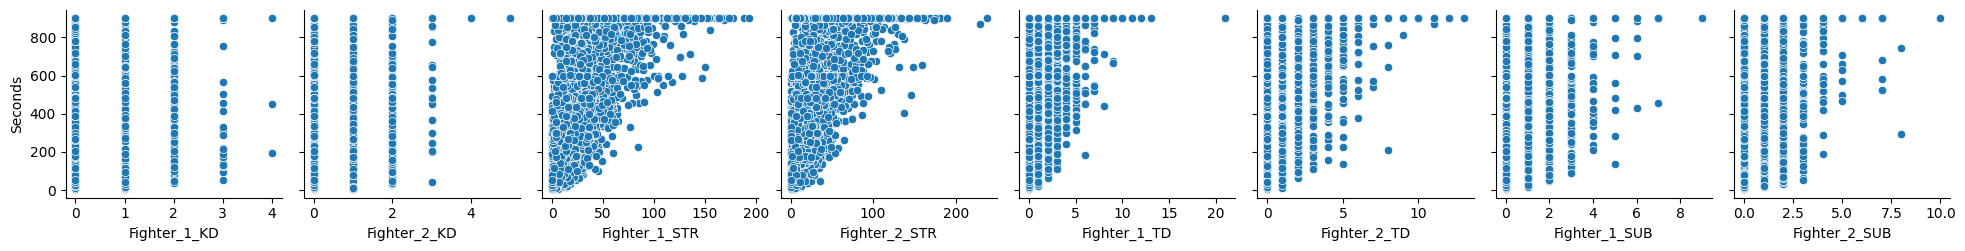

In [49]:
sns.pairplot(winrates_df_for_plot,   x_vars=['Fighter_1_KD', 'Fighter_2_KD','Fighter_1_STR',   'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD','Fighter_1_SUB', 'Fighter_2_SUB'], y_vars="Seconds")

### !!! REMOVE OUTLIERS

## MEAN OF RESIDUALS

In [50]:
predidted_time = model_Time.fit().predict(winrates_df_model)

residuals = winrates_df["Seconds"] - predidted_time

mean_of_residuals = residuals.sum()/residuals.size

mean_of_residuals

6.260928325112204e-13

OK!

## CHECK FOR HOMOSKEDASTICITY

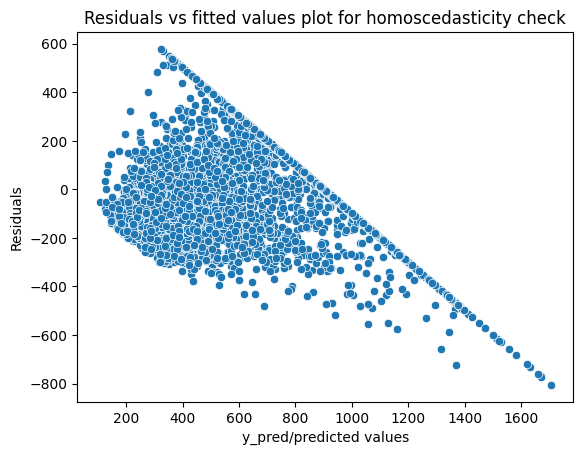

In [51]:

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Null Hypothesis: Error terms are homoscedastic

Alternative Hypothesis: Error terms are heteroscedastic.

In [52]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, winrates_df_model)
lzip(name, test)

[('F statistic', 0.9161090867339263), ('p-value', 0.9922076765990342)]

We can not reject null hypotheses

In [53]:
bartlett(predictions, residuals)

BartlettResult(statistic=530.177944563766, pvalue=2.583664013140946e-117)

In [54]:
het_white(residuals, model_Time.exog)


(1138.7097857308922,
 4.0289157647715854e-140,
 7.670182789906169,
 5.254255950803511e-159)

## NORMALITY

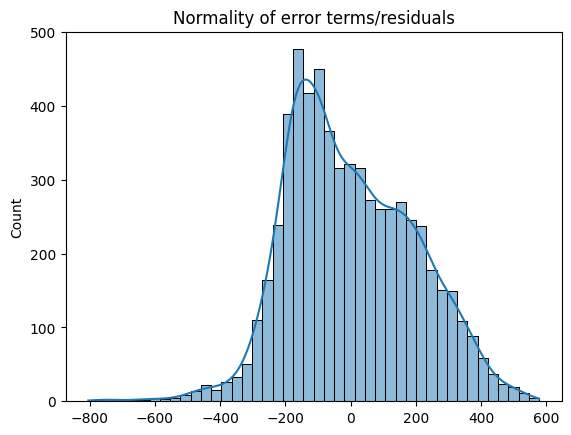

In [55]:
p = sns.histplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

Normal OK

In [56]:
normaltest(residuals)

NormaltestResult(statistic=42.94745281743149, pvalue=4.721490441350516e-10)

Not normal 

## AUTOCORRELATION

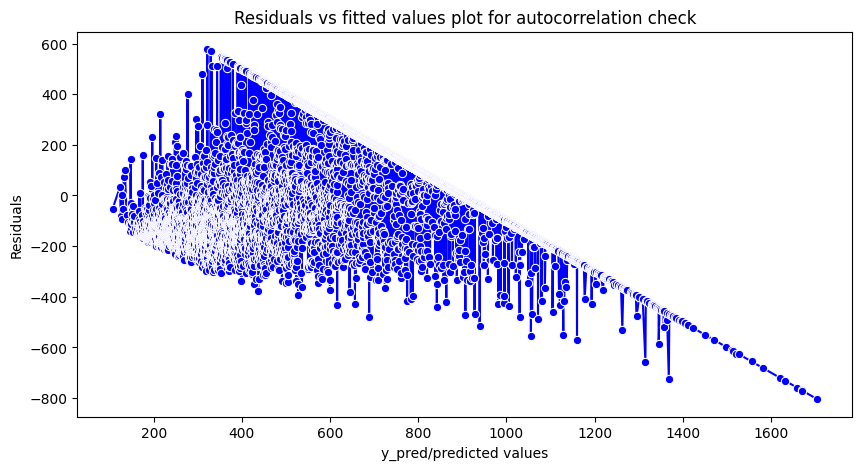

In [57]:
plt.figure(figsize=(10,5))
p = sns.lineplot(y=residuals,x=predidted_time,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

In [58]:
diag.acorr_ljungbox(residuals, lags=12)

,lb_stat,lb_pvalue
1,7.852376,5.075395e-03
2,23.896418,6.470810e-06
3,24.291070,2.171755e-05
4,40.035144,4.256586e-08
5,45.359609,1.226037e-08
6,49.353760,6.334027e-09
7,49.439255,1.860940e-08
8,53.393347,9.050017e-09
9,61.700681,6.295799e-10
10,68.636564,8.122907e-11


Not autocorrelated

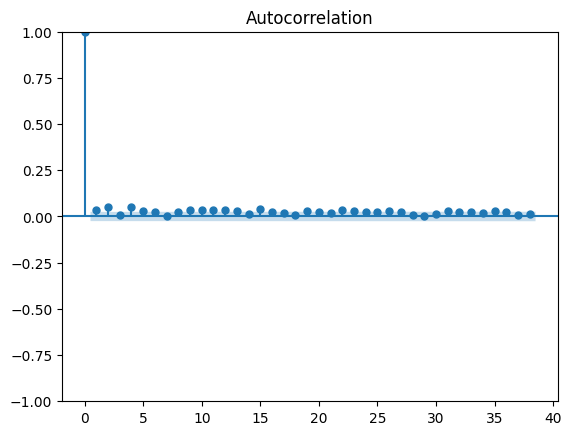

In [59]:
sm.graphics.tsa.plot_acf(residuals)
plt.show()

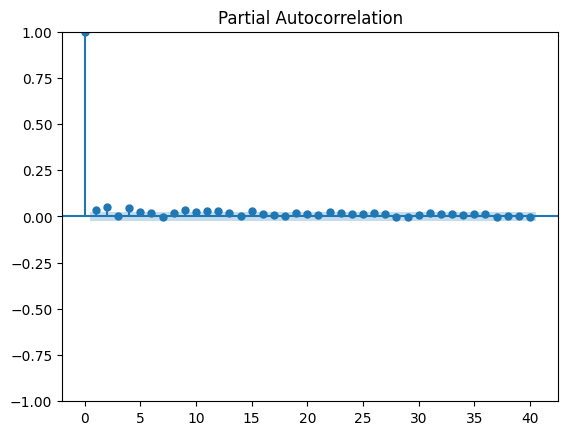

In [60]:
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

## NO PERFECT COLLINEARITY

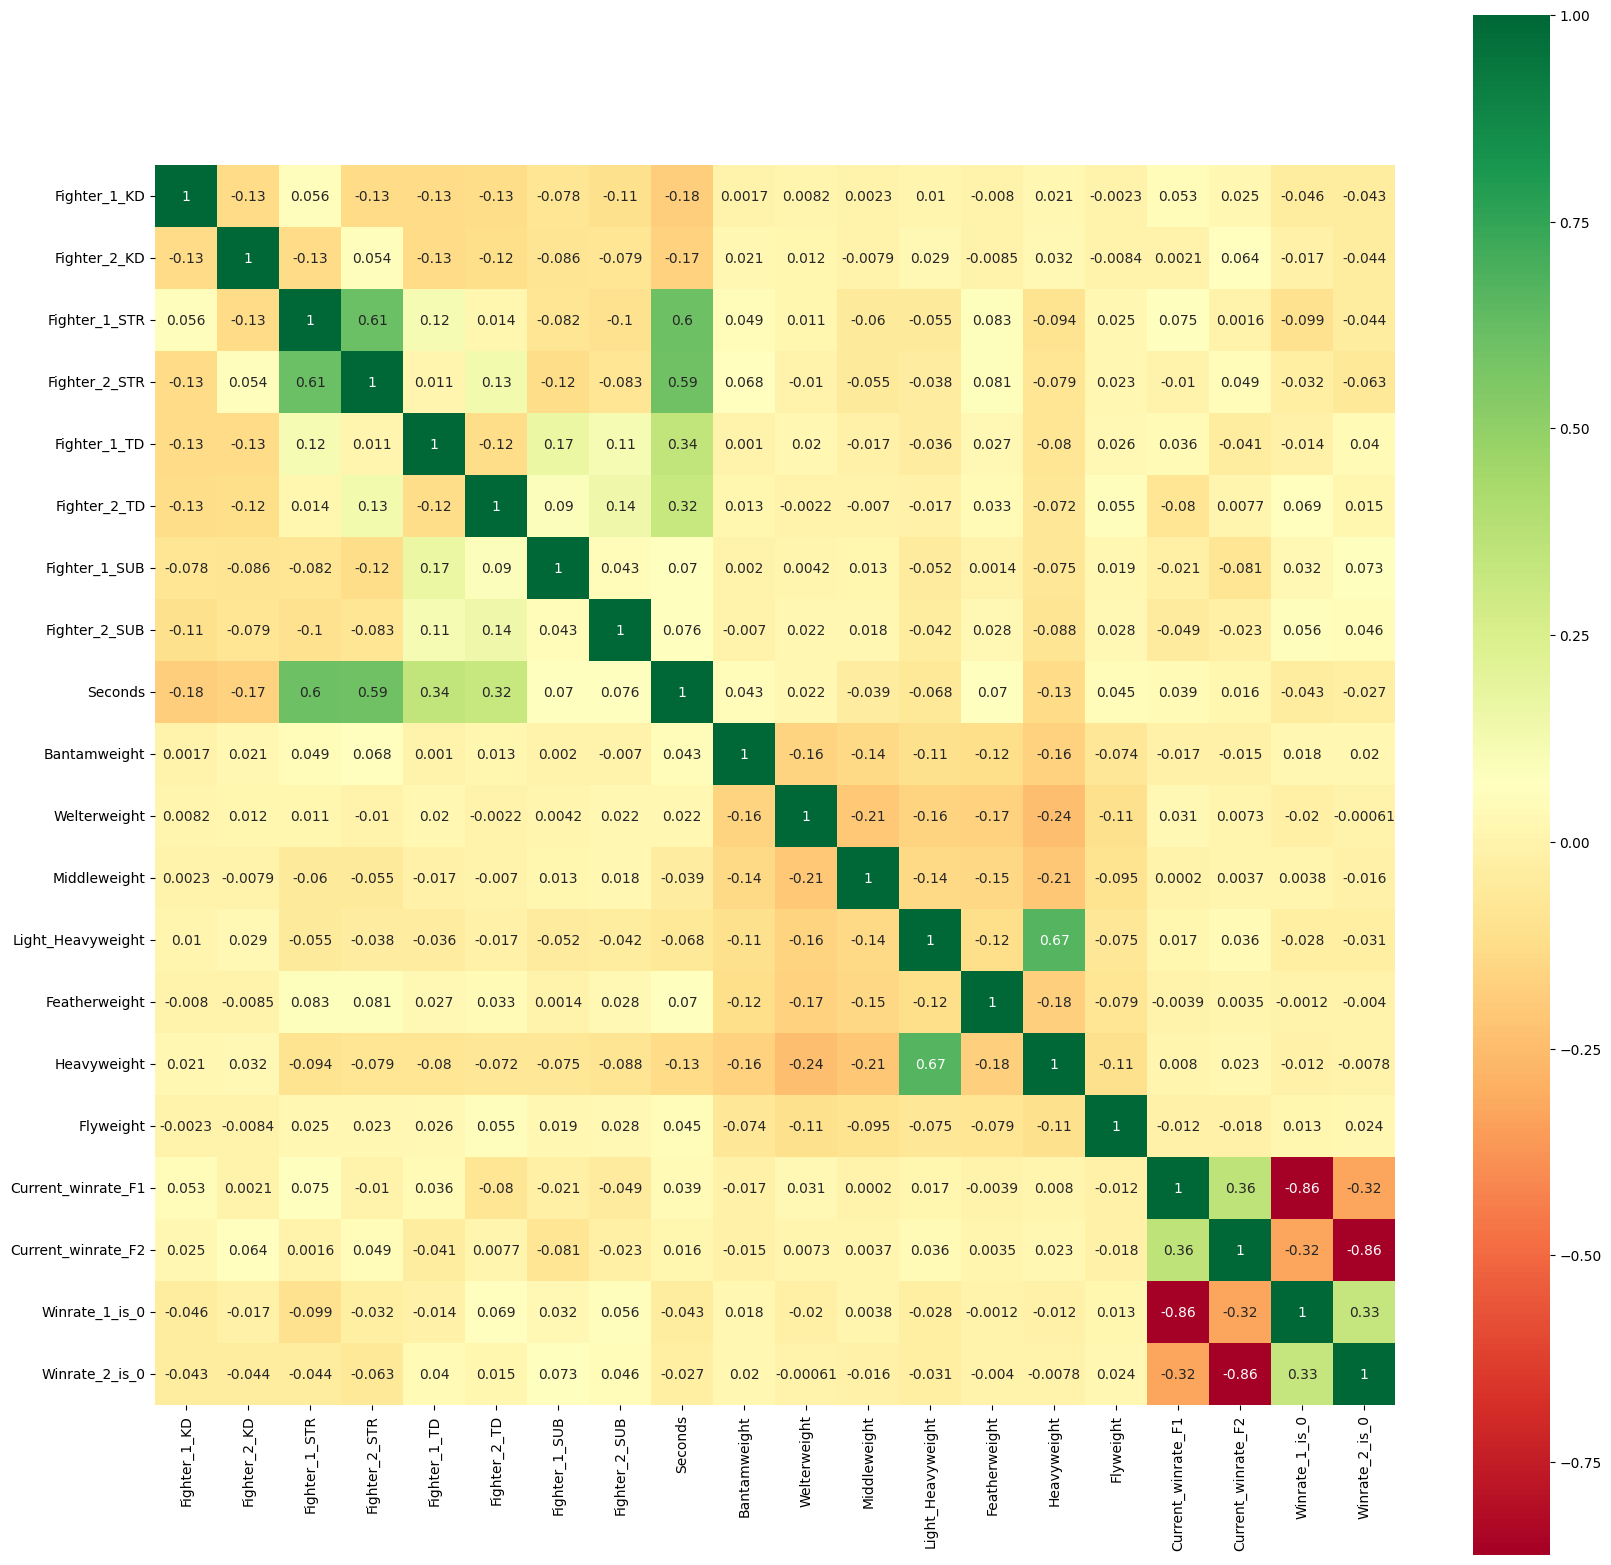

In [61]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

plt.figure(figsize=(20,20)) 
p=sns.heatmap(winrates_df_model.corr(), annot=True,cmap='RdYlGn',square=True)  

OK

## OUTLIERS CLEAN

In [62]:
winrates_df_model.columns

Index(['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB',
       'Seconds', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

<Axes: >

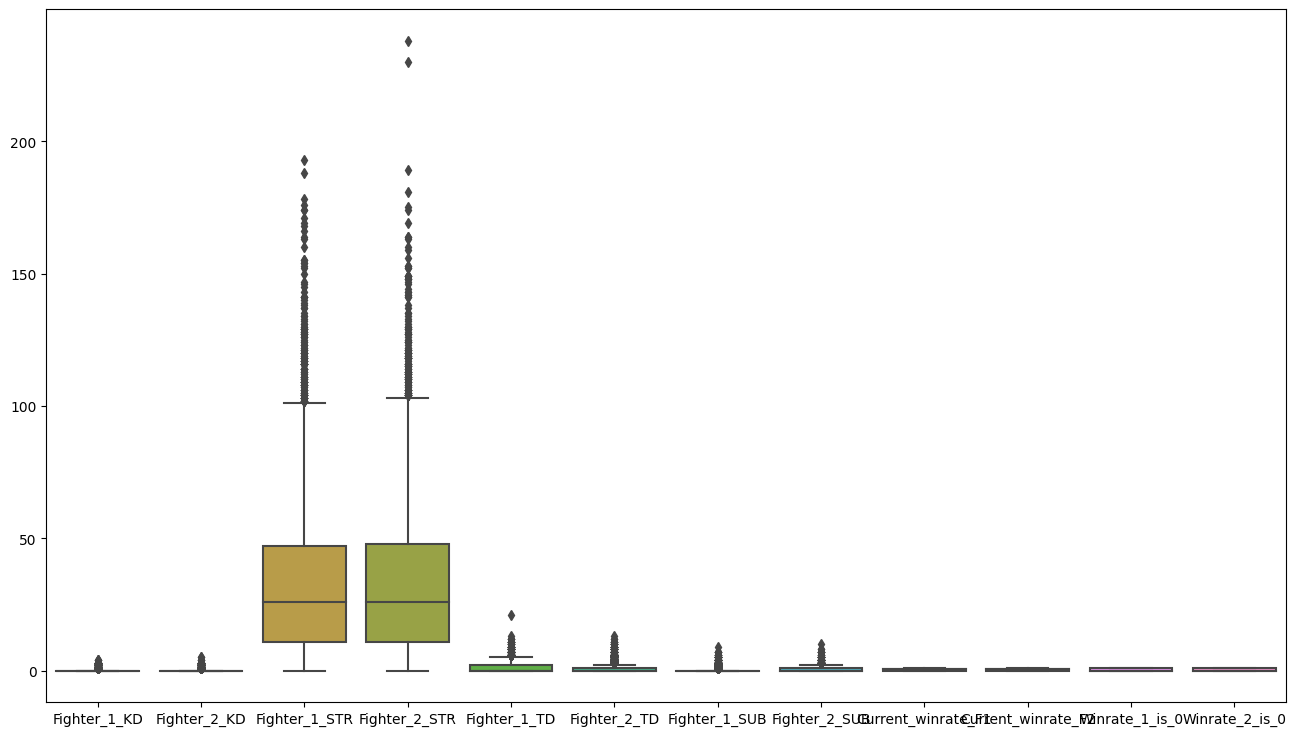

In [63]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

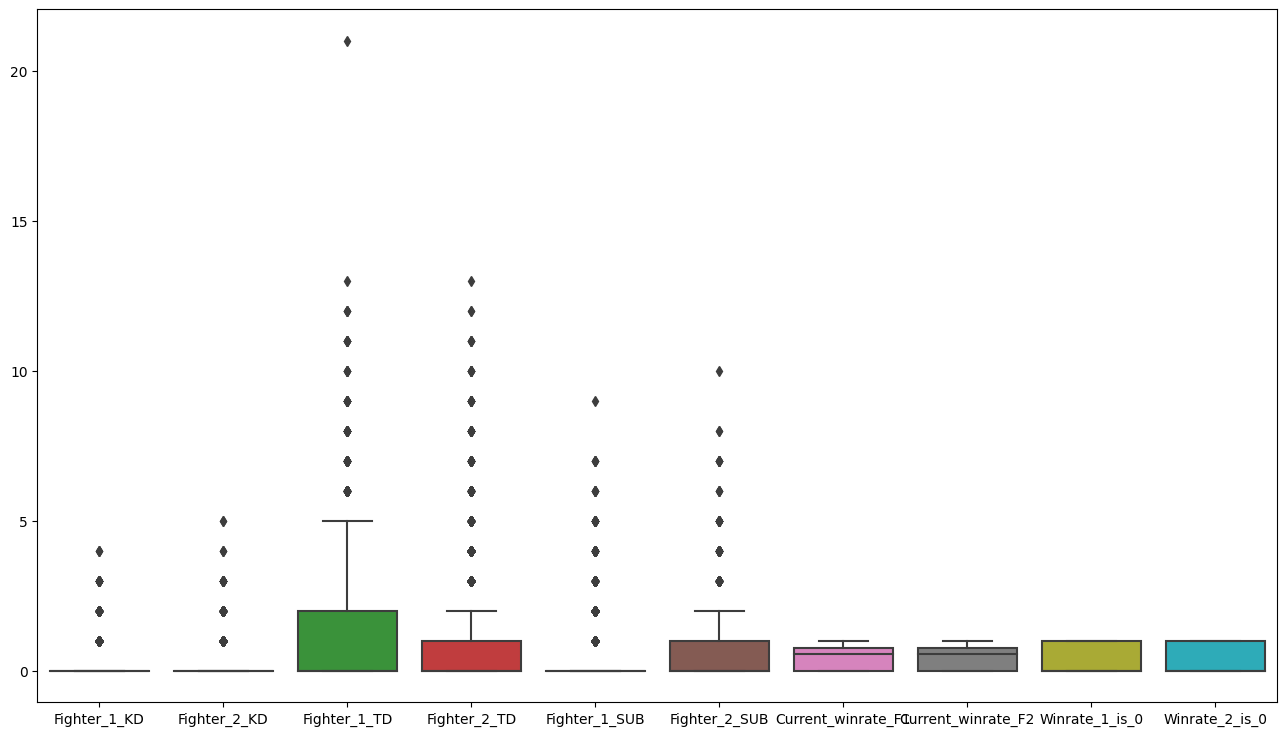

In [64]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

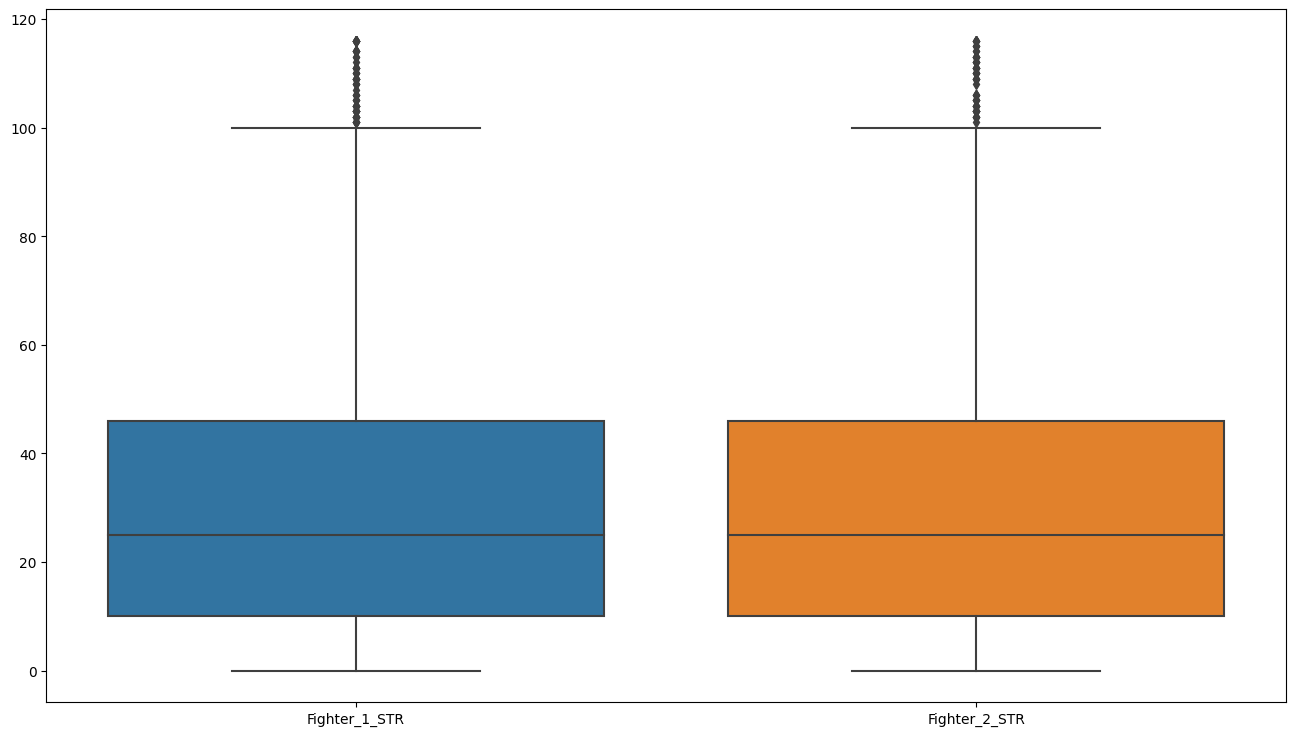

In [65]:
a = winrates_df_model[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)]

plt.figure(figsize=(16,9))
sns.boxplot(a[['Fighter_1_STR', 'Fighter_2_STR']])

In [66]:
outliners_off = a.reset_index(drop=True)

In [67]:
new_m = smf.ols(f"Seconds ~ {' + '.join(outliners_off.drop(['Seconds'], axis=1))}", data=outliners_off).fit()
new_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     609.0
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:29:03   Log-Likelihood:                -33325.
No. Observations:                5029   AIC:                         6.669e+04
Df Residuals:                    5009   BIC:                         6.682e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            144.0688     15.941      9.037      0.000     112.816     175.321
Fighter_1_KD         -70.2934      7.102     -9.897      0.000     -84.217     -56.370
Fighter_2_KD         -76.9447      6.984    -11.017      0.000     -90.637     -63.252
Fighter_1_STR          4.9860      0.136     36.700      0.000       4.720       5.252
Fighter_2_STR          4.7200      0.137     34.562      0.000       4.452       4.988
Fighter_1_TD          67.4613      2.042     33.041      0.000      63.458      71.464
Fighter_2_TD          64.2327      2.232     28.774      0.000      59.856      68.609
Fighter_1_SUB         -3.3016      4.730     -0.698      0.485     -12.575       5.972
Fighter_2_SUB         12.7441      4.662      2.733      0.006       3.604      21.884
Bantamweight          -1.3341     10.212     -0.131      0.896     -21.355      18.686
Welterweight           8.7970      8.328      1.056      0.291      -7.529      25.123
Middleweight           4.2580      8.783      0.485      0.628     -12.960      21.476
Light_Heavyweight     -3.1678     11.266     -0.281      0.779     -25.253      18.918
Featherweight        -24.5442      9.777     -2.510      0.012     -43.711      -5.377
Heavyweight           -5.9256      9.839     -0.602      0.547     -25.214      13.362
Flyweight             -0.9350     13.357     -0.070      0.944     -27.121      25.251
Current_winrate_F1    51.7444     14.765      3.505      0.000      22.799      80.690
Current_winrate_F2    -0.2417     14.931     -0.016      0.987     -29.512      29.029
Winrate_1_is_0        27.1803     11.690      2.325      0.020       4.264      50.097
Winrate_2_is_0        -7.8511     11.751     -0.668      0.504     -30.888      15.186
==============================================================================
Omnibus:                      100.801   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.442
Skew:                           0.352   Prob(JB):                     7.70e-24
Kurtosis:                       3.114   Cond. No.                         474.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

a - norm df

1) Dummy STR remain
2)  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


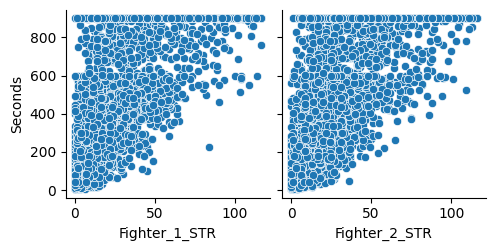

In [68]:
sns.pairplot(outliners_off,   x_vars=['Fighter_1_STR',   'Fighter_2_STR'], y_vars="Seconds")

Remove heteroskedasticity

1) Methode one:

In [69]:
for_fight_str = np.where(a['Fighter_1_STR'] <= 65, 0, 1)
for_second_str = np.where(a['Fighter_2_STR'] <= 65, 0, 1)

df_for_hetero = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

hetero_check_1 = pd.concat([outliners_off, df_for_hetero], axis=1)

In [70]:
hetero_1 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_1.drop(['Seconds'], axis=1))}", data=hetero_check_1).fit()
hetero_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     662.6
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:29:04   Log-Likelihood:                -32992.
No. Observations:                5029   AIC:                         6.603e+04
Df Residuals:                    5007   BIC:                         6.617e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             87.9793     15.071      5.838      0.000      58.434     117.525
Fighter_1_KD         -77.7104      6.666    -11.658      0.000     -90.778     -64.643
Fighter_2_KD         -81.7901      6.566    -12.457      0.000     -94.662     -68.918
Fighter_1_STR          6.6916      0.173     38.669      0.000       6.352       7.031
Fighter_2_STR          6.6081      0.174     38.041      0.000       6.268       6.949
Fighter_1_TD          58.9373      1.941     30.363      0.000      55.132      62.743
Fighter_2_TD          55.4227      2.118     26.171      0.000      51.271      59.574
Fighter_1_SUB         -0.4699      4.430     -0.106      0.916      -9.155       8.215
Fighter_2_SUB         16.3474      4.367      3.744      0.000       7.786      24.908
Bantamweight          -0.7182      9.560     -0.075      0.940     -19.460      18.023
Welterweight          10.9224      7.797      1.401      0.161      -4.363      26.207
Middleweight           4.1799      8.222      0.508      0.611     -11.938      20.298
Light_Heavyweight     -1.5272     10.546     -0.145      0.885     -22.202      19.148
Featherweight        -21.1817      9.153     -2.314      0.021     -39.126      -3.238
Heavyweight           -3.4735      9.211     -0.377      0.706     -21.531      14.584
Flyweight              0.5950     12.504      0.048      0.962     -23.918      25.108
Current_winrate_F1    52.1541     13.823      3.773      0.000      25.055      79.253
Current_winrate_F2     2.5774     13.978      0.184      0.854     -24.825      29.980
Winrate_1_is_0        32.4947     10.945      2.969      0.003      11.038      53.952
Winrate_2_is_0        -3.8245     11.001     -0.348      0.728     -25.392      17.743
Fighter_1_Tough     -191.0463     11.474    -16.651      0.000    -213.540    -168.553
Fighter_2_Tough     -207.5312     11.340    -18.301      0.000    -229.762    -185.300
==============================================================================
Omnibus:                      124.170   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.584
Skew:                           0.362   Prob(JB):                     1.33e-30
Kurtosis:                       3.366   Cond. No.                         476.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

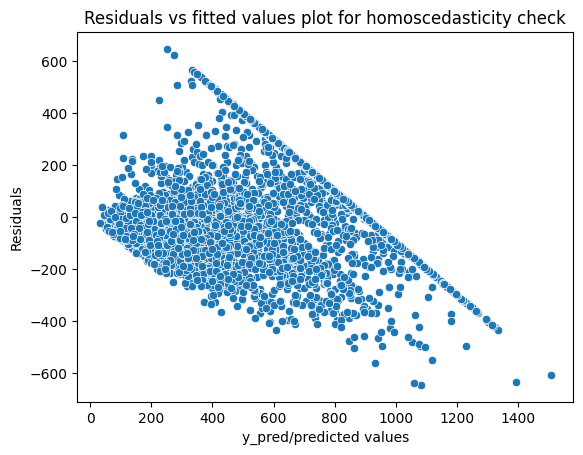

In [71]:
predidted_time = hetero_1.predict(hetero_check_1)

residuals = (hetero_check_1["Seconds"] - predidted_time).dropna()

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [72]:
hetero_21 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_1.drop(['Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight', 'Seconds'], axis=1))}", data=hetero_check_1).fit()
hetero_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     991.7
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:29:04   Log-Likelihood:                -32999.
No. Observations:                5029   AIC:                         6.603e+04
Df Residuals:                    5014   BIC:                         6.613e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             88.4583     14.320      6.177      0.000      60.386     116.531
Fighter_1_KD         -78.2780      6.665    -11.744      0.000     -91.345     -65.211
Fighter_2_KD         -81.8055      6.568    -12.455      0.000     -94.682     -68.929
Fighter_1_STR          6.6854      0.173     38.666      0.000       6.346       7.024
Fighter_2_STR          6.5902      0.174     37.974      0.000       6.250       6.930
Fighter_1_TD          58.8660      1.937     30.384      0.000      55.068      62.664
Fighter_2_TD          55.4773      2.111     26.278      0.000      51.339      59.616
Fighter_1_SUB         -0.4566      4.424     -0.103      0.918      -9.130       8.217
Fighter_2_SUB         16.4110      4.355      3.768      0.000       7.873      24.949
Current_winrate_F1    52.6970     13.827      3.811      0.000      25.591      79.803
Current_winrate_F2     2.0592     13.974      0.147      0.883     -25.336      29.455
Winrate_1_is_0        32.7437     10.948      2.991      0.003      11.281      54.207
Winrate_2_is_0        -4.4706     10.994     -0.407      0.684     -26.023      17.082
Fighter_1_Tough     -191.1128     11.477    -16.652      0.000    -213.612    -168.613
Fighter_2_Tough     -207.9861     11.345    -18.332      0.000    -230.228    -185.744
==============================================================================
Omnibus:                      122.344   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.656
Skew:                           0.358   Prob(JB):                     3.49e-30
Kurtosis:                       3.368   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
predicted = hetero_21.predict(hetero_check_1)

residuals = hetero_check_1['Seconds'] - predicted

mean_er = residuals.sum()/residuals.shape[0]

mean_er

-2.502964142481075e-13

In [84]:
accuracy_win = hetero_check_1.copy()

accuracy_win["Second_Pred"] = predicted
accuracy_win["Round_Pred"] = accuracy_win["Second_Pred"].apply(second_to_round)
accuracy_win["Round"] = accuracy_win["Seconds"].apply(second_to_round)

conf_mat = metrics.confusion_matrix(accuracy_win["Round"], accuracy_win["Round_Pred"])
f_1_score = metrics.f1_score(accuracy_win["Round"], accuracy_win["Round_Pred"], average="macro")

pred_accuracy = (accuracy_win["Round_Pred"] == accuracy_win["Round"]).value_counts()

print(f"Accuracy: {round(pred_accuracy[0]/(pred_accuracy[0]+pred_accuracy[1]),2)}")
print(f_1_score)

Accuracy: 0.63
0.32617424705869275


In [89]:
np.unique(np.where(abs(accuracy_win["Second_Pred"] - accuracy_win["Seconds"]) <= 30, 1, 0), return_counts=True)

(array([0, 1]), array([4307,  722]))

In [92]:
4963/(722+4307)

0.9868761185126268

In [91]:
np.unique(np.where(abs(accuracy_win["Round_Pred"] - accuracy_win["Round"]) <= 1, 1, 0), return_counts=True)

(array([0, 1]), array([  66, 4963]))

## Logit model updated

In [74]:
def improve_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Improve the dataframe ability to construct good OLS models
    """
    outlieners_off = df[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)].reset_index(drop=True)
    
    for_fight_str = np.where(outlieners_off['Fighter_1_STR'] <= 65, 0, 1)
    for_second_str = np.where(outlieners_off['Fighter_2_STR'] <= 65, 0, 1)

    df_for_tough = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

    tough_df = pd.concat([outlieners_off, df_for_tough], axis=1)

    result = tough_df.drop(['Lightweight','Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight'], axis=1).reset_index(drop=True)

    return result
        

In [75]:
test = improve_df(winrates_df)
test

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Method,Winner,Seconds,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0,Fighter_1_Tough,Fighter_2_Tough
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,KO/TKO Punch,0,64.0,0.77,0.88,0,0,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,KO/TKO Punches,0,169.0,0.59,0.56,0,0,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,U-DEC,0,900.0,0.75,0.75,0,0,0,0
3,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,U-DEC,0,900.0,0.53,0.56,0,0,0,0
4,Punahele Soriano,Dustin Stoltzfus,0.0,1.0,31.0,64.0,0.0,4.0,0.0,1.0,SUB Rear Naked Choke,0,550.0,0.50,0.20,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,Adriano Santos,Tulio Palhares,0.0,0.0,11.0,31.0,2.0,4.0,0.0,0.0,KO/TKO Punches,0,540.0,0.00,0.00,1,1,0,0
5025,Pete Williams,Mark Coleman,1.0,0.0,22.0,26.0,0.0,3.0,1.0,0.0,KO/TKO Kick,1,338.0,0.00,0.00,1,1,0,0
5026,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,KO/TKO Punches,0,43.0,0.00,0.00,1,1,0,0
5027,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,SUB Keylock,1,661.0,0.00,0.00,1,1,0,0


In [76]:
winrates_df.loc[(winrates_df["Fighter_1"] == "Conor McGregor") | (winrates_df["Fighter_2"] == "Conor McGregor")]['Seconds']

935     300.0
1116    452.0
1464     40.0
2707    484.0
2965    552.0
3055     13.0
3236    597.0
3429    414.0
3556    106.0
3635    245.0
4042    900.0
4164     67.0
Name: Seconds, dtype: float64

In [77]:
test

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Method,Winner,Seconds,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0,Fighter_1_Tough,Fighter_2_Tough
0,Beneil Dariush,Arman Tsarukyan,0.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,KO/TKO Punch,0,64.0,0.77,0.88,0,0,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,KO/TKO Punches,0,169.0,0.59,0.56,0,0,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,U-DEC,0,900.0,0.75,0.75,0,0,0,0
3,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,U-DEC,0,900.0,0.53,0.56,0,0,0,0
4,Punahele Soriano,Dustin Stoltzfus,0.0,1.0,31.0,64.0,0.0,4.0,0.0,1.0,SUB Rear Naked Choke,0,550.0,0.50,0.20,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,Adriano Santos,Tulio Palhares,0.0,0.0,11.0,31.0,2.0,4.0,0.0,0.0,KO/TKO Punches,0,540.0,0.00,0.00,1,1,0,0
5025,Pete Williams,Mark Coleman,1.0,0.0,22.0,26.0,0.0,3.0,1.0,0.0,KO/TKO Kick,1,338.0,0.00,0.00,1,1,0,0
5026,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,KO/TKO Punches,0,43.0,0.00,0.00,1,1,0,0
5027,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,SUB Keylock,1,661.0,0.00,0.00,1,1,0,0


In [78]:
winrates_df_model_logit = test.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=test)
model_logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.323777
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Winner   No. Observations:                 5029
Model:                          Logit   Df Residuals:                     5014
Method:                           MLE   Df Model:                           14
Date:                Thu, 25 Apr 2024   Pseudo R-squ.:                  0.5328
Time:                        20:29:05   Log-Likelihood:                -1628.3
converged:                       True   LL-Null:                       -3485.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1327      0.257      0.515      0.606      -0.372       0.637
Fighter_1_KD           2.2631      0.138     16.395      0.000       1.993       2.534
Fighter_2_KD          -2.1354      0.134    -15.877      0.000      -2.399      -1.872
Fighter_1_STR          0.0933      0.004     23.844      0.000       0.086       0.101
Fighter_2_STR         -0.0986      0.004    -24.390      0.000      -0.107      -0.091
Fighter_1_TD           0.4651      0.037     12.624      0.000       0.393       0.537
Fighter_2_TD          -0.3737      0.039     -9.574      0.000      -0.450      -0.297
Fighter_1_SUB          0.9862      0.081     12.138      0.000       0.827       1.145
Fighter_2_SUB         -1.0531      0.081    -12.948      0.000      -1.213      -0.894
Current_winrate_F1     0.3773      0.253      1.494      0.135      -0.118       0.872
Current_winrate_F2    -0.5263      0.256     -2.057      0.040      -1.028      -0.025
Winrate_1_is_0        -0.1951      0.202     -0.966      0.334      -0.591       0.201
Winrate_2_is_0         0.0158      0.201      0.078      0.938      -0.378       0.410
Fighter_1_Tough       -0.3919      0.212     -1.846      0.065      -0.808       0.024
Fighter_2_Tough        0.8873      0.209      4.251      0.000       0.478       1.296
======================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.323777
         Iterations 7


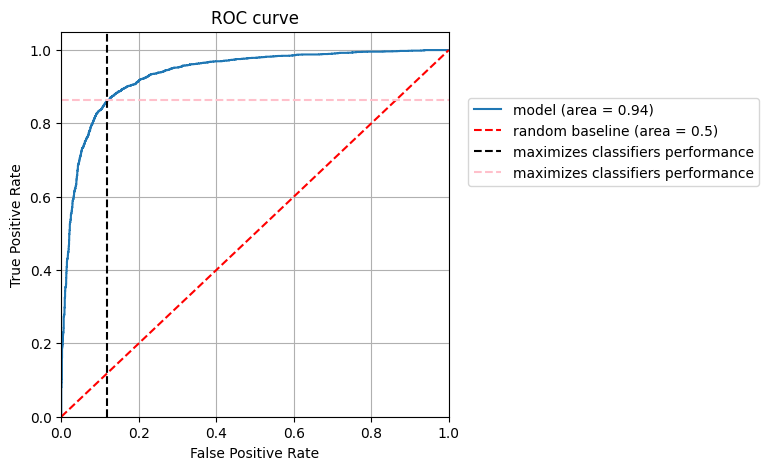

In [79]:
def plot_roc_curve(y_true, y_pred_prob):

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_true=y_true, y_score=y_pred_prob), 2)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f'model (area = {auc})')
    plt.plot([0, 1], [0, 1], 'r--', label='random baseline (area = 0.5)')

    id_x = pd.Series(abs(tpr - fpr), index=fpr).idxmax()
    plt.axvline(x=id_x, linestyle='dashed', color='black',
                label='maximizes classifiers performance')
    id_y = pd.Series(abs(tpr - fpr), index=tpr).idxmax()
    plt.axhline(y=id_y, linestyle='dashed', color='pink',
                label='maximizes classifiers performance')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc=(1.05, 0.6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

y_pred = model_logit.fit().predict(test)

plot_roc_curve(test['Winner'], y_pred)

In [96]:
predictions_logit = np.where(y_pred > 0.5, 1, 0)

tp_and_fp = (test["Winner"] == predictions_logit).value_counts()

print(f"The accuracy score fot logit model: {(tp_and_fp[0]/(tp_and_fp[0]+tp_and_fp[1]))}")

The accuracy score fot logit model: 0.871743885464307


In [97]:
metrics.f1_score(test['Winner'], predictions_logit)

0.8703517587939699

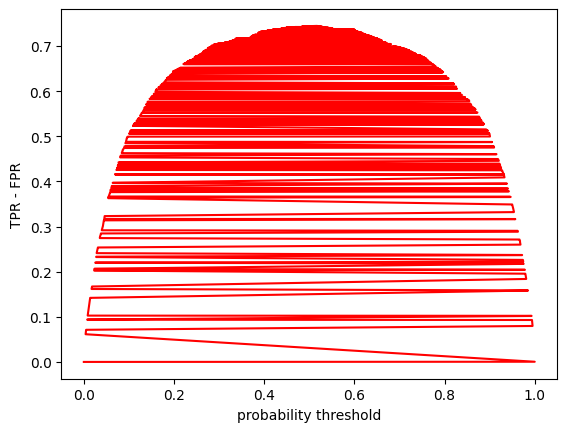

In [80]:
fpr, tpr, thresholds = metrics.roc_curve(test['Winner'], y_pred)
df2 = pd.DataFrame()
df2['tpr'] = tpr
df2['fpr'] = fpr
df2['obj'] = abs(tpr - fpr)
df2['thresholds'] = thresholds
df2 = df2.sort_values('obj', ascending=False).copy()

df2 = df2[df2.thresholds < 1]
plt.plot(df2['thresholds'], df2['obj'], color='red')
plt.ylabel('TPR - FPR')
plt.xlabel('probability threshold')
plt.show()

In [81]:
df2.sort_values('obj', ascending=False)

,tpr,fpr,obj,thresholds
498,0.863289,0.118804,0.744485,0.515868
518,0.871331,0.127459,0.743872,0.498003
516,0.870929,0.127065,0.743864,0.499911
490,0.860072,0.116444,0.743629,0.522677
488,0.859670,0.116050,0.743620,0.523924
...,...,...,...,...
1012,0.999598,0.937844,0.061754,0.003973
1013,0.999598,0.938238,0.061360,0.003941
1011,0.999196,0.937844,0.061352,0.004037
1,0.000402,0.000000,0.000402,0.999992


In [82]:
metrics.f1_score(test['Winner'], np.where(y_pred < 0.5, 0, 1))

0.8703517587939699